<a href="https://colab.research.google.com/github/Ayush-Sharma15/Zeotap/blob/main/Ayush_Sharma_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
customers_df = pd.read_csv("https://raw.githubusercontent.com/Ayush-Sharma15/Zeotap/refs/heads/main/Customers.csv")
transactions_df = pd.read_csv("https://raw.githubusercontent.com/Ayush-Sharma15/Zeotap/refs/heads/main/Transactions.csv")

merged_df = pd.merge(customers_df, transactions_df, on="CustomerID", how="inner")

print(merged_df.head())


  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  
0      P054  2024-01-19 03:12:55         2      114.60   57.30  
1      P022  2024-09-17 09:01:18         3      412.62  137.54  
2      P096  2024-04-08 00:01:00         2      614.94  307.47  
3      P083  2024-05-07 03:11:44         2      911.44  455.72  
4      P029  2024-11-02 17:04:16         3     1300.92  433.64  


In [ ]:
# Replace invalid values and clean the SignupDate column
customers_df["SignupDate"] = customers_df["SignupDate"].replace(["NA", "Invalid", "None"], None)
customers_df["SignupDate"] = customers_df["SignupDate"].str.extract(r"(\d{2}-\d{2}-\d{4})")[0]

# Convert to datetime with error handling
customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"], errors="coerce", dayfirst=True)

# Check for invalid dates and handle them
if customers_df["SignupDate"].isna().sum() > 0:
    print("Invalid dates found in SignupDate, replacing with a default date.")
    customers_df["SignupDate"].fillna(pd.Timestamp("2000-01-01"), inplace=True)

# Extract the year from SignupDate
customers_df["SignupYear"] = customers_df["SignupDate"].dt.year


Invalid dates found in SignupDate, replacing with a default date.


<ipython-input-20-f3e8738deae8>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df["SignupDate"].fillna(pd.Timestamp("2000-01-01"), inplace=True)


In [ ]:
# Ensure TransactionDate is cleaned and converted
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"], errors="coerce")

# Aggregate transaction metrics
agg_transactions = transactions_df.groupby("CustomerID").agg({
    "TransactionID": "count",
    "TotalValue": "sum"
}).rename(columns={"TransactionID": "TransactionCount", "TotalValue": "TotalSpent"})

# Merge the transaction metrics with customer data
merged_df = pd.merge(customers_df, agg_transactions, on="CustomerID", how="left")

# Fill NaN values in TransactionCount and TotalSpent with 0
merged_df["TransactionCount"].fillna(0, inplace=True)
merged_df["TotalSpent"].fillna(0, inplace=True)


<ipython-input-21-753d0994694a>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["TransactionCount"].fillna(0, inplace=True)
<ipython-input-21-753d0994694a>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [ ]:
# One-hot encode categorical columns
region_encoded = pd.get_dummies(merged_df["Region"], prefix="Region", drop_first=True)

# Combine with the main DataFrame
merged_df = pd.concat([merged_df, region_encoded], axis=1)


In [ ]:
# Define features
features = ["SignupYear", "TransactionCount", "TotalSpent"] + list(region_encoded.columns)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[features])


In [ ]:
# Apply KMeans with a predefined number of clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
merged_df["Cluster"] = kmeans.fit_predict(scaled_features)

print("Clusters assigned to customers:")
print(merged_df[["CustomerID", "Cluster"]].head())


Clusters assigned to customers:
  CustomerID  Cluster
0      C0001        1
1      C0002        3
2      C0003        1
3      C0004        1
4      C0005        3


In [ ]:
# Compute DB Index
db_index = davies_bouldin_score(scaled_features, merged_df["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 1.03


<ipython-input-26-3f6f21addc0f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=merged_df, palette="Set2")


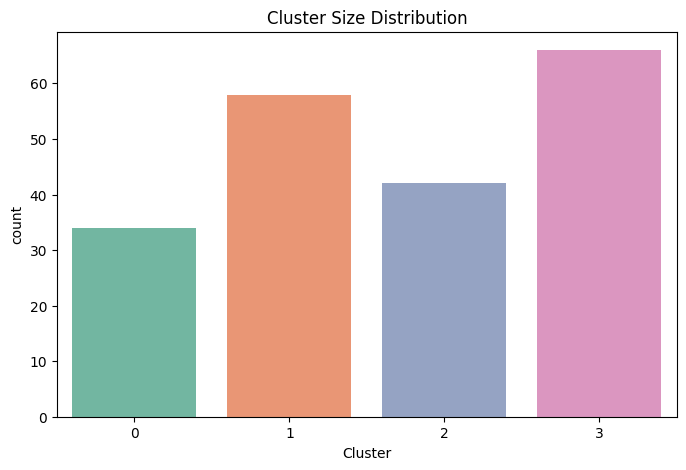

In [ ]:
# Cluster size distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=merged_df, palette="Set2")
plt.title("Cluster Size Distribution")
plt.show()


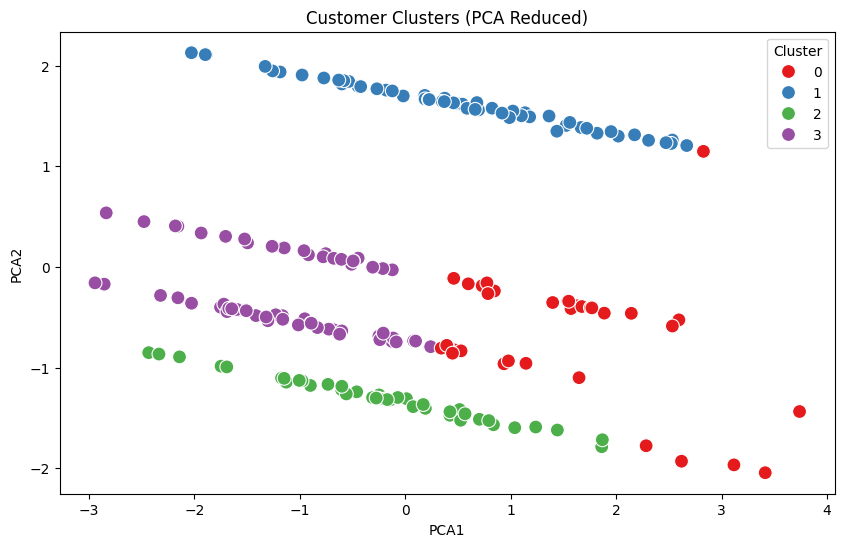

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
merged_df["PCA1"] = reduced_features[:, 0]
merged_df["PCA2"] = reduced_features[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=merged_df, palette="Set1", s=100
)
plt.title("Customer Clusters (PCA Reduced)")
plt.show()


Cluster Centers:
   SignupYear  TransactionCount   TotalSpent  Region_Europe  \
0      2000.0          7.676471  5730.939118   3.235294e-01   
1      2000.0          5.086207  3666.283793  -1.110223e-16   
2      2000.0          4.857143  2963.207619  -1.665335e-16   
3      2000.0          3.636364  2394.612879   5.909091e-01   

   Region_North America  Region_South America  Cluster  
0          1.176471e-01          2.941176e-02        0  
1          3.330669e-16          1.000000e+00        1  
2          1.000000e+00         -1.110223e-16        2  
3          3.608225e-16         -2.220446e-16        3  


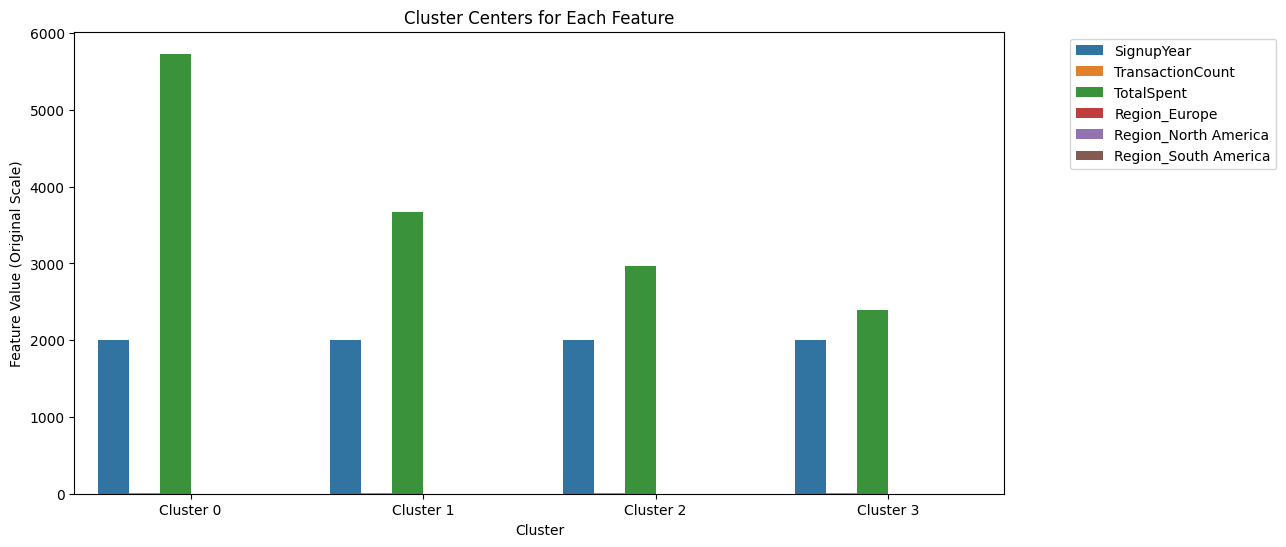

In [ ]:
# Extract cluster centers and inverse transform to original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)

# Add cluster labels to the centers
cluster_centers_df["Cluster"] = range(num_clusters)

# Display the cluster centers
print("Cluster Centers:")
print(cluster_centers_df)

# Visualize cluster centers
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_centers_df.melt(id_vars="Cluster"), x="Cluster", y="value", hue="variable")
plt.title("Cluster Centers for Each Feature")
plt.ylabel("Feature Value (Original Scale)")
plt.xticks(ticks=range(num_clusters), labels=[f"Cluster {i}" for i in range(num_clusters)])
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()


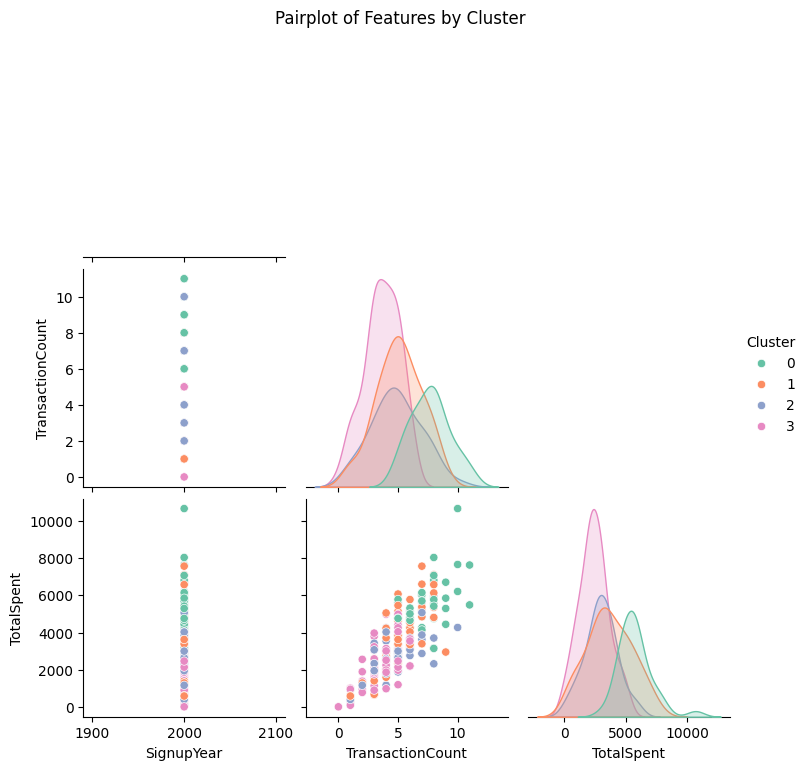

In [ ]:
# Sample data for pairplot (to avoid overcrowding)
sample_df = merged_df.sample(n=min(500, len(merged_df)), random_state=42)

# Pairplot with clusters
sns.pairplot(sample_df, vars=["SignupYear", "TransactionCount", "TotalSpent"], hue="Cluster", palette="Set2", diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Features by Cluster", y=1.02)
plt.show()


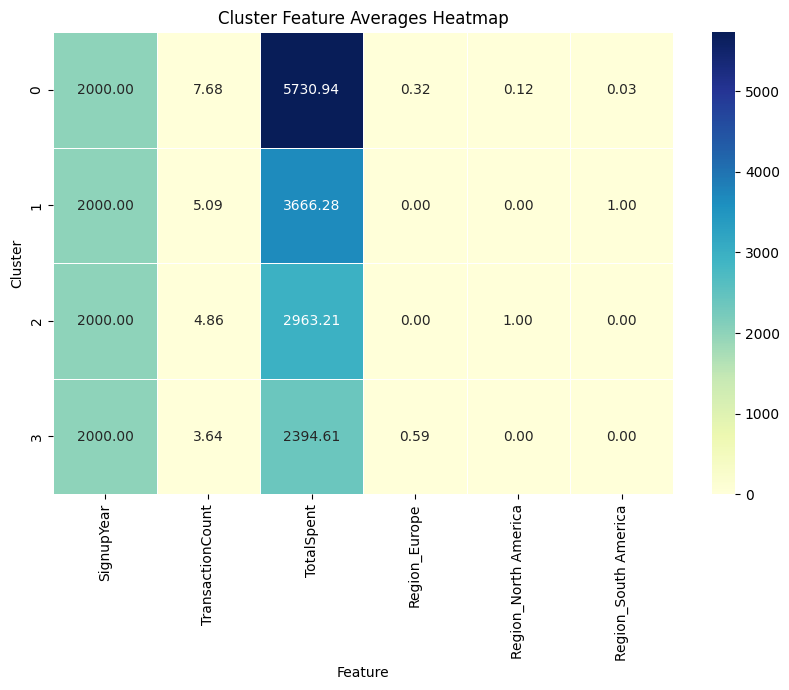

In [ ]:
# Compute feature averages per cluster
cluster_summary = merged_df.groupby("Cluster")[features].mean()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Cluster Feature Averages Heatmap")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Compute silhouette scores
silhouette_vals = silhouette_samples(scaled_features, merged_df["Cluster"])

# Silhouette plot
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(num_clusters):
    ith_cluster_silhouette_values = silhouette_vals[merged_df["Cluster"] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        alpha=0.7,
        label=f"Cluster {i}"
    )
    y_lower = y_upper + 10

plt.axvline(x=silhouette_score(scaled_features, merged_df["Cluster"]), color="red", linestyle="--")
plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")
plt.legend()
plt.show()
